In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
df = pd.read_csv('spam_ham_dataset.csv', encoding="latin-1")


In [ ]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Initial exploration
print(df.head())
print(df.info())

   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
None


In [ ]:
# Drop unnecessary columns
df.drop(columns=['Unnamed: 0'], inplace=True)

# Rename columns
df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)

In [ ]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

In [ ]:
# Check for null values and duplicates
print(df.isnull().sum())
print(df.duplicated().sum())

label        0
text         0
label_num    0
dtype: int64
178


In [ ]:
# Drop duplicates
df = df.drop_duplicates(keep='first')
print(df.shape)

(4993, 3)


In [ ]:
# Data visualization
values = df['label'].value_counts()
total = values.sum()

percentage_0 = (values[0] / total) * 100
percentage_1 = (values[1] / total) * 100

print('Percentage of 0 (Ham):', percentage_0)
print('Percentage of 1 (Spam):', percentage_1)

Percentage of 0 (Ham): 70.71900660925296
Percentage of 1 (Spam): 29.280993390747046


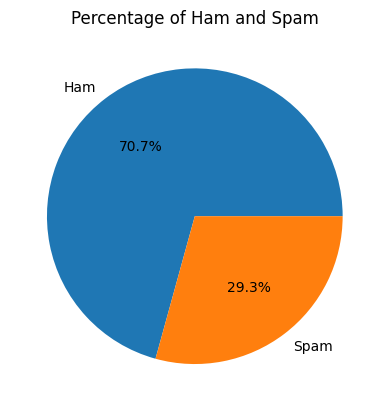

In [ ]:
# Plot pie chart
labels = ['Ham', 'Spam']
percentages = [percentage_0, percentage_1]

plt.pie(percentages, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Ham and Spam')
plt.show()

In [ ]:
# Feature engineering
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentence'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

<ipython-input-13-0815e659e0fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_characters'] = df['text'].apply(len)


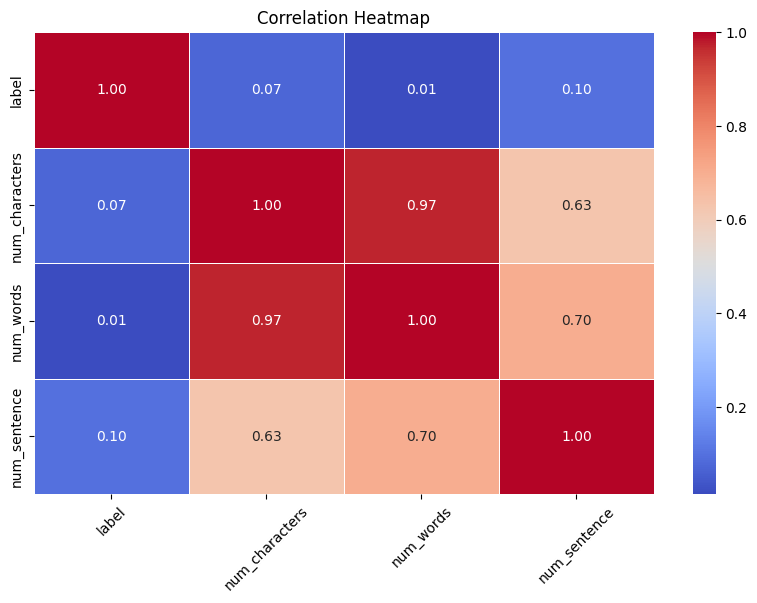

In [ ]:
# Correlation heatmap
correlation_matrix = df[['label', 'num_characters', 'num_words', 'num_sentence']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Text preprocessing
from nltk.stem.porter import PorterStemmer
import string

ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = [ps.stem(i) for i in text if i.isalnum() and i not in stopwords.words('english') and i not in string.punctuation]
    return " ".join(y)

df['transformed_text'] = df['text'].apply(transform_text)

In [ ]:
# TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(max_features=3000)
X = tfid.fit_transform(df['transformed_text']).toarray()
y = df['label'].values


In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

# Model initialization
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

svc = SVC(probability=True)
mnb = MultinomialNB()
dtc = DecisionTreeClassifier()
lrc = LogisticRegression()
rfc = RandomForestClassifier()

clfs = {
    'SVC': svc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
}


In [ ]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'SVC': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10, 100],
        'gamma': [0.01, 0.1, 1, 10]
    },
    'NB': {},
    'DT': {
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10]
    },
    'LR': {
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10, 100]
    },
    'RF': {
        'n_estimators': [50, 100, 200],
        'max_features': ['auto', 'sqrt', 'log2']
    }
}

In [ ]:
best_estimators = {}
for name, clf in clfs.items():
    grid_search = GridSearchCV(clf, param_grid[name], cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_estimators[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters for SVC: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for NB: {}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for DT: {'max_depth': 30, 'min_samples_split': 5}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Best parameters for LR: {'C': 10, 'penalty': 'l2'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for RF: {'max_features': 'log2', 'n_estimators': 100}


In [ ]:
# Cross-validation
from sklearn.model_selection import cross_val_score

for name, clf in best_estimators.items():
    cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

SVC Cross-Validation Accuracy: 0.99 (+/- 0.01)
NB Cross-Validation Accuracy: 0.95 (+/- 0.01)
DT Cross-Validation Accuracy: 0.93 (+/- 0.02)
LR Cross-Validation Accuracy: 0.99 (+/- 0.01)
RF Cross-Validation Accuracy: 0.98 (+/- 0.01)


In [ ]:
# Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_pred_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    return accuracy, precision, recall, f1, roc_auc

# Initialize evaluation_metrics list to store results
evaluation_metrics = []

for name, clf in best_estimators.items():
    accuracy, precision, recall, f1, roc_auc = evaluate_classifier(clf, X_test, y_test)
    print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}")
    evaluation_metrics.append((name, accuracy, precision, recall, f1, roc_auc))

SVC - Accuracy: 0.98, Precision: 0.97, Recall: 0.98, F1-score: 0.97, ROC-AUC: 1.00
NB - Accuracy: 0.93, Precision: 0.85, Recall: 0.94, F1-score: 0.89, ROC-AUC: 0.98
DT - Accuracy: 0.94, Precision: 0.87, Recall: 0.92, F1-score: 0.90, ROC-AUC: 0.94
LR - Accuracy: 0.98, Precision: 0.97, Recall: 0.97, F1-score: 0.97, ROC-AUC: 1.00
RF - Accuracy: 0.98, Precision: 0.96, Recall: 0.97, F1-score: 0.97, ROC-AUC: 1.00


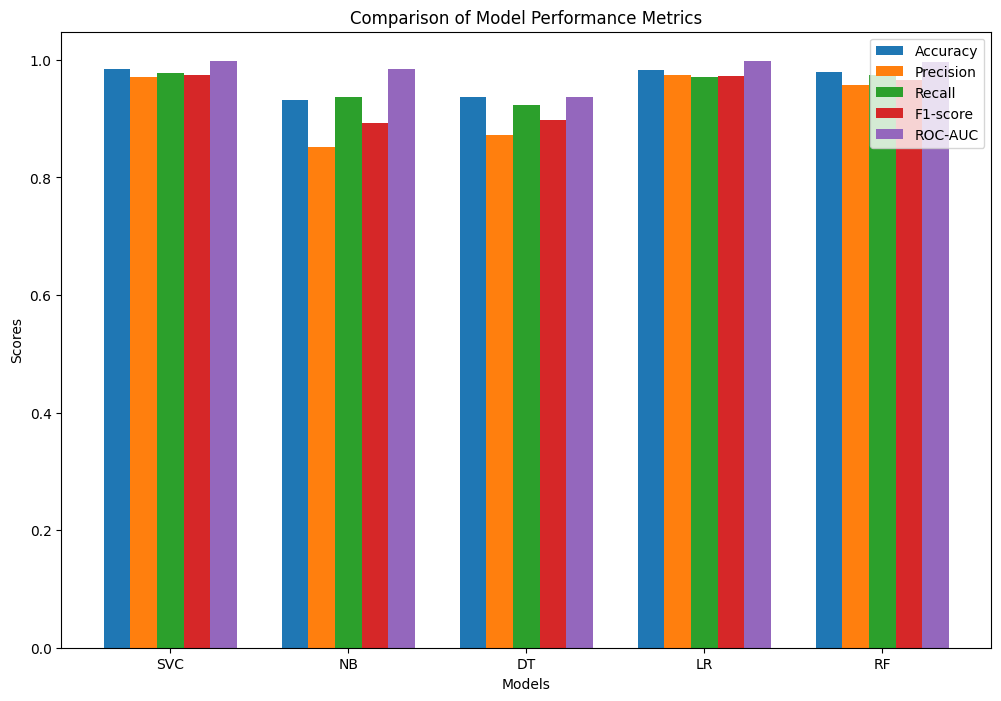

In [ ]:
# Visualization of model performance
names, accuracies, precisions, recalls, f1_scores, roc_aucs = zip(*evaluation_metrics)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
values = [accuracies, precisions, recalls, f1_scores, roc_aucs]

x = np.arange(len(names))  # the label locations
width = 0.15

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - 2*width, accuracies, width, label='Accuracy')
rects2 = ax.bar(x - width, precisions, width, label='Precision')
rects3 = ax.bar(x, recalls, width, label='Recall')
rects4 = ax.bar(x + width, f1_scores, width, label='F1-score')
rects5 = ax.bar(x + 2*width, [r if r is not None else 0 for r in roc_aucs], width, label='ROC-AUC')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()
